In [30]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, lit, regexp_replace, count, median, lower, sum
from pyspark.sql.types import StructType, StructField, StringType, LongType, DateType
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

ss = SparkSession.builder \
    .appName("Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()
ss

In [8]:
sp_df = ss.createDataFrame(pd.read_csv('https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv').replace({np.nan: None})[['patientid', 'age', 'sex', 'finding', 'view', 'date']])
sp_df.printSchema()

sp_df.show(5, 0)

print(f'\nВсего строк - {sp_df.count()}')

root
 |-- patientid: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)

+---------+----+---+------------------------+----+----------------+
|patientid|age |sex|finding                 |view|date            |
+---------+----+---+------------------------+----+----------------+
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 22, 2020|
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 27, 2020|
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 28, 2020|
|4        |52.0|F  |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|
+---------+----+---+------------------------+----+----------------+
only showing top 5 rows

Всего строк - 950


Смотрим пропущенные значения в колонках

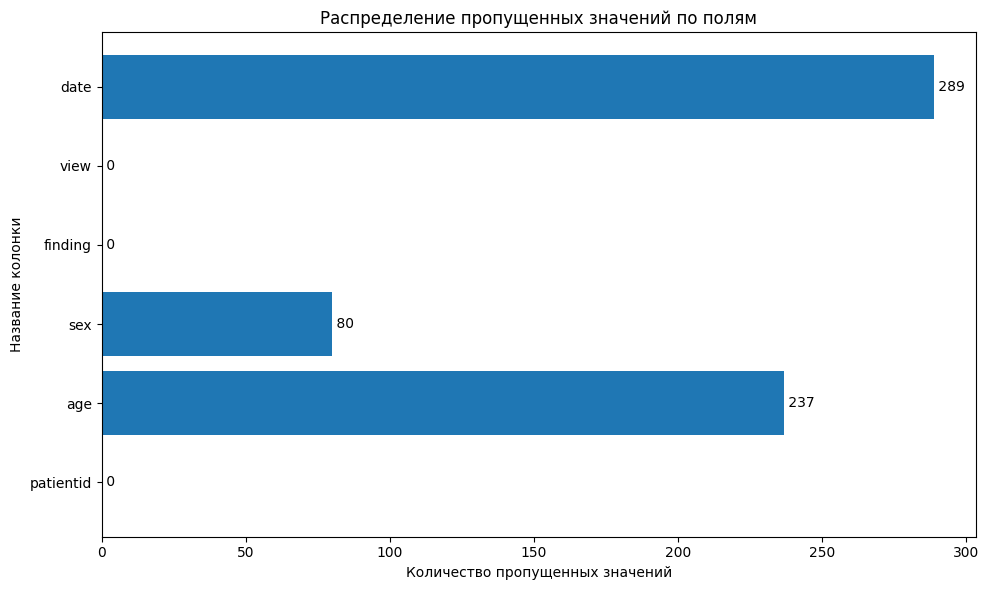

In [9]:
results = []

for column in sp_df.columns:
    cnt_null = sp_df.select(sum(when(col(column).isNull(), lit(1)).otherwise(lit(0)))).collect()[0][0]
    results.append((column, cnt_null))

df_null = pd.DataFrame(results, columns=["name_col", "cnt_null"])

plt.figure(figsize=(10, 6))
bars = plt.barh(df_null['name_col'], df_null['cnt_null'])
plt.xlabel('Количество пропущенных значений')
plt.ylabel('Название колонки')
plt.title('Распределение пропущенных значений по полям')
plt.tight_layout()

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f' {int(width)}', va='center', ha='left')

plt.show()

Смотрим аномалии в колонке age

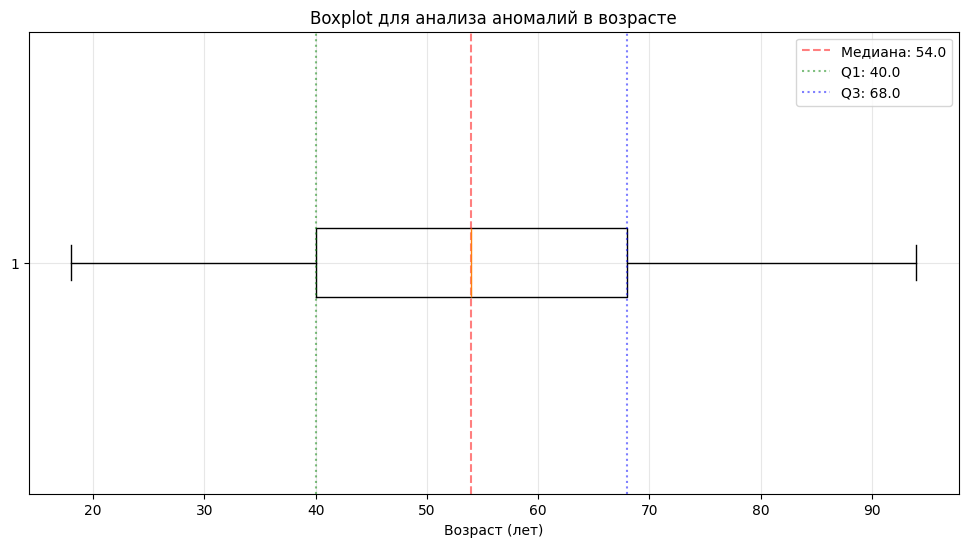

Всего записей с возрастом: 713

Пропущено: 237

Количество выбросов: 0


In [10]:
age = sp_df.select(regexp_replace(col('age'), ',', '.').cast('float').alias('age')).where(col('age').isNotNull()).toPandas()['age']

plt.figure(figsize=(12, 6))
plt.boxplot(age.dropna(), vert=False)
plt.title('Boxplot для анализа аномалий в возрасте')
plt.xlabel('Возраст (лет)')
plt.grid(True, alpha=0.3)

median_val = age.median()
q1 = age.quantile(0.25)
q3 = age.quantile(0.75)

plt.axvline(x=median_val, color='red', linestyle='--', alpha=0.5, label=f'Медиана: {median_val:.1f}')
plt.axvline(x=q1, color='green', linestyle=':', alpha=0.5, label=f'Q1: {q1:.1f}')
plt.axvline(x=q3, color='blue', linestyle=':', alpha=0.5, label=f'Q3: {q3:.1f}')

plt.legend()
plt.show()

print(f'Всего записей с возрастом: {len(age)}')
print(f'\nПропущено: {sp_df.where(col('age').isNull()).count()}')

iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f'\nКоличество выбросов: {len(age[(age < lower_bound) | (age > upper_bound) | (age < 0) | (age > 120)])}')

Смотрим, какие значения есть в колонке sex

In [11]:
sp_df.where(col('sex').isNotNull()).groupBy('sex').count().orderBy(col('count').desc()).show(20, 0)

+---+-----+
|sex|count|
+---+-----+
|M  |559  |
|F  |311  |
+---+-----+



Сморим, какие значения есть в колонке date

In [12]:
sp_df.where(col('date').isNotNull()).groupBy('date').count().orderBy(col('count').desc()).show(100, 0)

+------------------+-----+
|date              |count|
+------------------+-----+
|2020              |454  |
|2015              |24   |
|2016              |20   |
|2014              |11   |
|2004              |11   |
|2013              |7    |
|Mar 4, 2020       |6    |
|2018              |6    |
|February 6, 2020  |6    |
|Mar 3, 2020       |5    |
|2011              |5    |
|March 10, 2020    |5    |
|March 2003        |5    |
|January 22, 2020  |4    |
|March 5, 2020     |4    |
|2010              |3    |
|2017              |3    |
|March 4, 2020     |3    |
|January 25, 2020  |3    |
|January 27, 2020  |3    |
|January 31, 2020  |2    |
|December 29, 2019 |2    |
|May 4, 2010       |2    |
|2019              |2    |
|January 19, 2020  |2    |
|March 7, 2020     |2    |
|Feb 21, 2020      |2    |
|January 1, 2020   |2    |
|January 26, 2020  |2    |
|2/29/2020         |2    |
|03/16/20          |2    |
|03/09/20          |2    |
|11/27/19          |2    |
|March 2020        |2    |
|

Создаем UDF для парсинга дат

In [13]:
def parse_date(date_str):
    if not date_str:
        return None
    date_str = str(date_str).strip()
    formats = [
        "%B %d, %Y",      # January 22, 2020
        "%b %d, %Y",      # Feb 18, 2020
        "%d %B %Y",       # 12 March 2020
        "%d %b %Y",       # 12 Mar 2020
        "%m/%d/%Y",       # 3/3/2020
        "%m/%d/%y",       # 03/16/20
        "%B %Y",          # March 2003
        "%b %Y",          # Mar 2003
        "%Y",             # 2014
        "%B %d",          # January 12
        "%b %d",          # Feb 18
        "%d %B",          # 12 March
        "%d %b",          # 12 Mar
    ]

    for c in formats:
        try:
            result = datetime.strptime(date_str, c).date()
            if c in ["%B %d", "%b %d", "%d %B", "%d %b"]:
                result = result.replace(year=2020)
            return result
        except:
            continue
    return None

Создаём udf для категоризации возраста

In [14]:
def categorize_age(age):
    age = float(age)
    if age < 18:
        return "0-17 (Ребёнок)"
    elif age < 30:
        return "18-29 (Молодой человек/девушка)"
    elif age < 45:
        return "30-44 (Взрослый)"
    elif age < 60:
        return "45-59 (Предпенсионный)"
    elif age < 75:
        return "60-74 (Пенсионер)"
    else:
        return "75+ (Пожилой)"

Создаём udf для унификации диагнозов

In [15]:
def unify_finding(finding):
    if finding is None:
        return "Unknown"
    finding_str = str(finding).lower().strip()

    # COVID-19 и родственные
    if any(word in finding_str for word in ["covid", "sars-cov-2", "coronavirus", "corona"]):
        return "COVID-19"

    # Все виды пневмоний в одну группу
    elif "pneumonia" in finding_str:
        return "Pneumonia"

    # ARDS
    elif "ards" in finding_str or "acute respiratory distress" in finding_str:
        return "ARDS"

    # Нормальные случаи
    elif any(word in finding_str for word in ["no finding", "normal", "clear"]):
        return "Normal"

    # Туберкулез
    elif "tuberculosis" in finding_str or "tb" in finding_str:
        return "Tuberculosis"

    # Все остальное
    else:
        # Короткие названия оставляем как есть, длинные упрощаем
        if "/" in finding_str:
            return finding_str.split("/")[0].strip().title()
        elif len(finding_str) > 30:
            return "Other"
        else:
            return finding_str.title()

In [16]:
# Заполнение пропусков в возрасте медианным значением
median_age = sp_df.where(col("age").isNotNull()).agg(median("age")).collect()[0][0]
sp_df = sp_df.withColumn("age", when(col("age").isNull(), median_age).otherwise(col("age")))

# Заполнение пропусков в поле наиболее частым значением
most_common_sex = sp_df.where(col("sex").isNotNull() & (col("sex") != "")).groupBy("sex").count().orderBy(col("count").desc()).first()[0]
sp_df = sp_df.withColumn("sex", when(col("sex").isNull(), most_common_sex).otherwise(col("sex")))

# Преобразование дат к одному формату и заполнение пропусков в дате наиболее частым значением
sp_df = sp_df.withColumn('date_parsed', udf(parse_date, DateType())(col('date')))
most_common_date = sp_df.where(col('date_parsed').isNotNull()) .groupBy('date_parsed').count().orderBy(col('count').desc()).first()[0]
sp_df = sp_df.withColumn('date_correct', when(col('date_parsed').isNotNull(), col('date_parsed')).otherwise(most_common_date))

# Категоризация возраста
sp_df = sp_df.withColumn('age_category', udf(categorize_age, StringType())(col('age')))

# Унификация диагнозов
sp_df = sp_df.withColumn('finding_unified', udf(unify_finding, StringType())(col('finding')))

# Удаление полных дубликатов
sp_df = sp_df.dropDuplicates()

sp_df = sp_df.drop('finding', 'date', 'date_parsed')
sp_df.show(5, 0)

+---------+----+---+----+------------+----------------------+---------------+
|patientid|age |sex|view|date_correct|age_category          |finding_unified|
+---------+----+---+----+------------+----------------------+---------------+
|4        |52.0|F  |PA  |2020-01-25  |45-59 (Предпенсионный)|COVID-19       |
|3        |74.0|M  |AP  |2004-01-01  |60-74 (Пенсионер)     |Pneumonia      |
|10       |73.0|F  |AP  |2004-01-01  |60-74 (Пенсионер)     |Pneumonia      |
|13       |35.0|M  |PA  |2020-01-19  |30-44 (Взрослый)      |COVID-19       |
|13       |35.0|M  |PA  |2020-01-24  |30-44 (Взрослый)      |COVID-19       |
+---------+----+---+----+------------+----------------------+---------------+
only showing top 5 rows


**SQL-аналитика**

In [17]:
sp_df.createOrReplaceTempView('temp_view')

Запрос 1. Базовая статистика по диагнозам

In [18]:
ss.sql("""
    select
    finding_unified
    ,count(*) as count_patients
    ,round(count(*) * 100 / sum(count(*)) over(), 2) as percentage
    ,round(avg(age), 1) as avg_age
    ,min(age) as min_age
    ,max(age) as max_age
    from temp_view
    group by finding_unified
    order by count_patients desc
""").show(20, 0)

+---------------+--------------+----------+-------+-------+-------+
|finding_unified|count_patients|percentage|avg_age|min_age|max_age|
+---------------+--------------+----------+-------+-------+-------+
|COVID-19       |437           |65.42     |55.6   |20.0   |94.0   |
|Pneumonia      |166           |24.85     |49.9   |18.0   |90.0   |
|Todo           |27            |4.04      |54.0   |54.0   |54.0   |
|Normal         |20            |2.99      |53.5   |22.0   |78.0   |
|Tuberculosis   |17            |2.54      |42.4   |20.0   |78.0   |
|Unknown        |1             |0.15      |54.0   |54.0   |54.0   |
+---------------+--------------+----------+-------+-------+-------+



Запрос 2. Распределение по полу и диагнозам

In [19]:
ss.sql("""
    select
    sex
    ,finding_unified
    ,count(*) as count
    ,round(count(*) * 100 / sum(count(*)) over (partition by sex), 2) as percentage_by_sex
    from temp_view
    group by
    sex
    ,finding_unified
    order by
    sex
    ,count desc
""").show(20, 0)


+---+---------------+-----+-----------------+
|sex|finding_unified|count|percentage_by_sex|
+---+---------------+-----+-----------------+
|F  |COVID-19       |129  |62.02            |
|F  |Pneumonia      |59   |28.37            |
|F  |Normal         |9    |4.33             |
|F  |Todo           |6    |2.88             |
|F  |Tuberculosis   |5    |2.4              |
|M  |COVID-19       |308  |66.96            |
|M  |Pneumonia      |107  |23.26            |
|M  |Todo           |21   |4.57             |
|M  |Tuberculosis   |12   |2.61             |
|M  |Normal         |11   |2.39             |
|M  |Unknown        |1    |0.22             |
+---+---------------+-----+-----------------+



Запрос 3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов)

In [20]:
ss.sql("""
    select
    patientid
    ,age
    ,sex
    ,finding_unified
    ,rank_in_finding
    from (
        select
        patientid
        ,age
        ,sex
        ,finding_unified
        ,row_number() over (partition by finding_unified order by age desc) as rank_in_finding
        from (
          select distinct
          patientid
          ,age
          ,sex
          ,finding_unified
          from temp_view
        ) q
    ) t
    where 1 = 1
    and rank_in_finding <= 3
    order by
    finding_unified
    ,rank_in_finding
""").show(20, 0)

+---------+----+---+---------------+---------------+
|patientid|age |sex|finding_unified|rank_in_finding|
+---------+----+---+---------------+---------------+
|326b     |94.0|M  |COVID-19       |1              |
|324b     |93.0|F  |COVID-19       |2              |
|200      |88.0|M  |COVID-19       |3              |
|325      |78.0|F  |Normal         |1              |
|315      |78.0|F  |Normal         |2              |
|478      |75.0|F  |Normal         |3              |
|460      |90.0|M  |Pneumonia      |1              |
|91       |80.0|F  |Pneumonia      |2              |
|340      |80.0|M  |Pneumonia      |3              |
|430      |54.0|F  |Todo           |1              |
|431      |54.0|F  |Todo           |2              |
|439      |54.0|M  |Todo           |3              |
|421      |78.0|M  |Tuberculosis   |1              |
|453      |70.0|M  |Tuberculosis   |2              |
|456      |58.0|M  |Tuberculosis   |3              |
|221      |54.0|M  |Unknown        |1         

Запрос 4. Анализ временных трендов по датам исследований

In [21]:
ss.sql("""
    select
    year(date_correct) as year
    ,month(date_correct) as month
    ,count(*) as count_studies
    ,count(distinct patientid) as unique_patients
    ,round(avg(age), 1) as avg_age
    from temp_view
    group by
    year(date_correct)
    ,month(date_correct)
    order by
    year
    ,month
""").show(20, 0)

+----+-----+-------------+---------------+-------+
|year|month|count_studies|unique_patients|avg_age|
+----+-----+-------------+---------------+-------+
|2003|3    |3            |3              |40.7   |
|2004|1    |5            |5              |52.8   |
|2007|1    |1            |1              |54.0   |
|2009|9    |3            |1              |30.0   |
|2010|1    |3            |2              |54.0   |
|2010|5    |2            |1              |40.0   |
|2010|10   |1            |1              |30.0   |
|2011|1    |3            |2              |46.7   |
|2013|1    |5            |3              |65.6   |
|2014|1    |6            |4              |50.7   |
|2015|1    |11           |8              |56.0   |
|2015|5    |1            |1              |65.0   |
|2016|1    |14           |8              |49.0   |
|2017|1    |3            |2              |40.7   |
|2017|6    |1            |1              |35.0   |
|2018|1    |3            |2              |76.7   |
|2019|1    |2            |1    

Запрос 5. Статистика по проекциям снимков и их связи с диагнозами

In [22]:
ss.sql("""
    select
    view
    ,finding_unified
    ,count(*) as count_images
    ,round(count(*) * 100 / sum(count(*)) over(partition by view), 2) as percentage_by_view
    ,round(avg(age), 1) as avg_age
    from temp_view
    group by
    view
    ,finding_unified
    order by
    view
    ,count_images desc
""").show(20, 0)

+---------+---------------+------------+------------------+-------+
|view     |finding_unified|count_images|percentage_by_view|avg_age|
+---------+---------------+------------+------------------+-------+
|AP       |COVID-19       |106         |71.62             |58.2   |
|AP       |Pneumonia      |35          |23.65             |52.5   |
|AP       |Normal         |5           |3.38              |60.6   |
|AP       |Tuberculosis   |2           |1.35              |45.5   |
|AP Erect |Pneumonia      |1           |100.0             |30.0   |
|AP Supine|COVID-19       |94          |72.87             |58.2   |
|AP Supine|Todo           |17          |13.18             |54.0   |
|AP Supine|Pneumonia      |15          |11.63             |48.9   |
|AP Supine|Normal         |2           |1.55              |49.5   |
|AP Supine|Unknown        |1           |0.78              |54.0   |
|Axial    |COVID-19       |44          |93.62             |50.2   |
|Axial    |Normal         |3           |6.38    

Фильтрация данных (например, только COVID-19 пациенты старше 18 лет)

In [23]:
filtered_df = sp_df.where((col("finding_unified") == "COVID-19") & (col("age") >= 18))
print(f'Всего записей: {sp_df.count()}')
print(f'После фильтрации (COVID-19, возраст ≥ 18): {filtered_df.count()}')

Всего записей: 668
После фильтрации (COVID-19, возраст ≥ 18): 437


**Сохранение результатов в оптимизированном формате**

In [24]:
filtered_df.write.mode("overwrite").parquet('parquet')
ss.read.parquet('parquet').show(20, 0)

+---------+----+---+---------+------------+----------------------+---------------+
|patientid|age |sex|view     |date_correct|age_category          |finding_unified|
+---------+----+---+---------+------------+----------------------+---------------+
|4        |52.0|F  |PA       |2020-01-25  |45-59 (Предпенсионный)|COVID-19       |
|13       |35.0|M  |PA       |2020-01-19  |30-44 (Взрослый)      |COVID-19       |
|13       |35.0|M  |PA       |2020-01-24  |30-44 (Взрослый)      |COVID-19       |
|15       |54.0|M  |PA       |2020-01-01  |45-59 (Предпенсионный)|COVID-19       |
|19       |55.0|F  |AP       |2020-01-23  |45-59 (Предпенсионный)|COVID-19       |
|20       |54.0|M  |PA       |2020-01-01  |45-59 (Предпенсионный)|COVID-19       |
|32       |43.0|M  |Axial    |2020-03-10  |30-44 (Взрослый)      |COVID-19       |
|36       |67.0|M  |PA       |2020-01-01  |60-74 (Пенсионер)     |COVID-19       |
|36       |67.0|M  |Axial    |2020-01-01  |60-74 (Пенсионер)     |COVID-19       |
|39 

**Визуализация**

In [25]:
df = sp_df.toPandas()

Круговая диаграмма распределения диагнозов

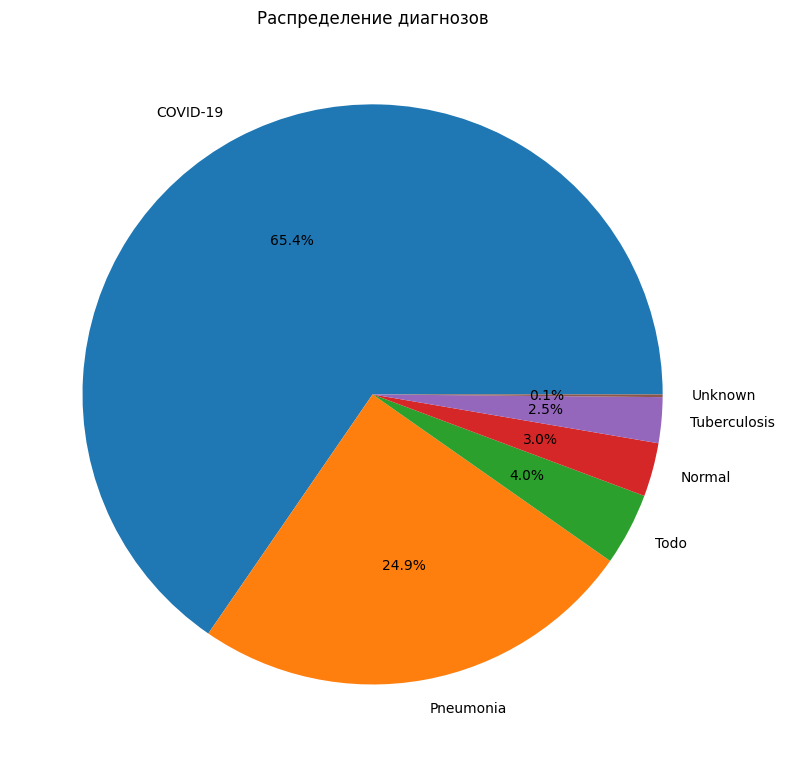

In [26]:
plt.figure(figsize=(8, 8))
df['finding_unified'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.title('Распределение диагнозов')
plt.tight_layout()
plt.show()

Столбчатая диаграмма по возрастным группам

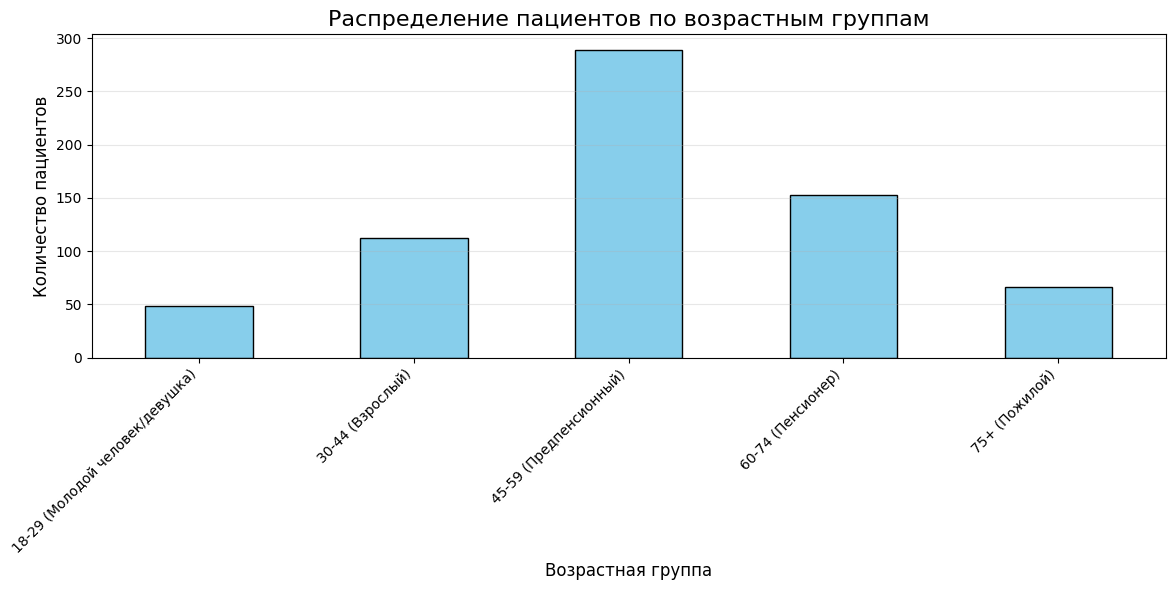

In [27]:
plt.figure(figsize=(12, 6))
age_group_counts = df['age_category'].value_counts().sort_index()
age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Распределение пациентов по возрастным группам', fontsize=16)
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

График временных трендов исследований

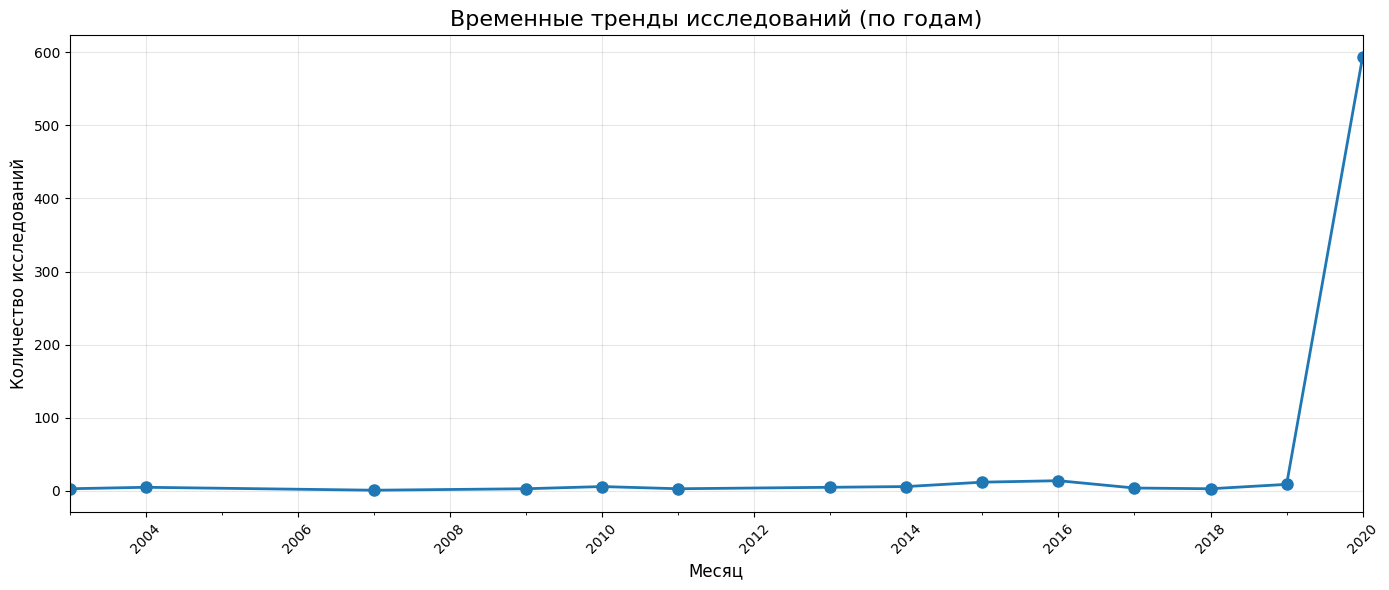

In [28]:
df['date_correct'] = pd.to_datetime(df['date_correct'])
year_data = df.groupby(df['date_correct'].dt.to_period('Y')).size()

plt.figure(figsize=(14, 6))
year_data.plot(kind='line', marker='o', linewidth=2, markersize=8)
plt.title('Временные тренды исследований (по годам)', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество исследований', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Heatmap распределения диагнозов по проекциям снимков

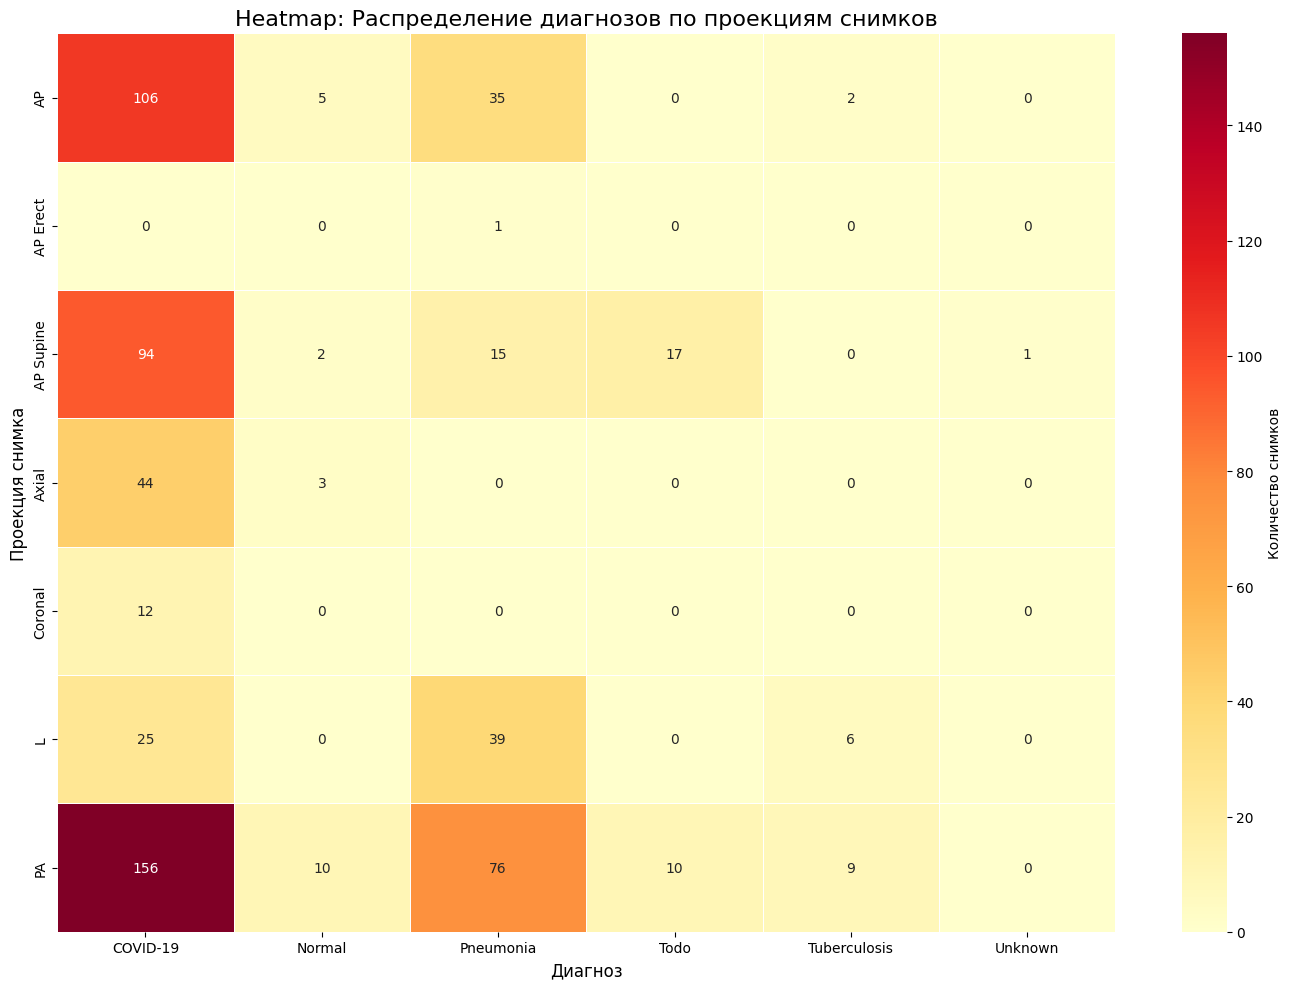

In [31]:
heatmap_data = df.groupby(['view', 'finding_unified']).size().unstack(fill_value=0)

top_views = df['view'].value_counts().head(10).index
heatmap_data = heatmap_data.loc[heatmap_data.index.isin(top_views)]

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5, cbar_kws={'label': 'Количество снимков'})
plt.title('Heatmap: Распределение диагнозов по проекциям снимков', fontsize=16)
plt.xlabel('Диагноз', fontsize=12)
plt.ylabel('Проекция снимка', fontsize=12)
plt.tight_layout()
plt.show()